In [2]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(15,8)


# Naiwny klasyfikator Bayesa

Z klasyfikatorem tym zapoznamy się próbując klasyfikować gatunki irysów. Jest to klasyczny już problem, często wykorzystywany przy porównywaniu różnych technik klasyfikacji. Więcej o pochodzeniu tych danych i problemie można przeczytać tu [https://en.wikipedia.org/wiki/Iris_flower_data_set]

Kod napiszemy w oparciu o implementacje klasyfikatora Bayesa z biblioteki <tt>scikit-learn</tt> [http://scikit-learn.org/stable/about.html#citing-scikit-learn]

Zaczerpniemy stamtąd:
* obiekt klasyfikatora <tt>GaussianNB</tt>
* zbiór danych
* funkcje do oceny jakości 

Zatem importujemy:

In [3]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Przyda nam się potem funkcja rysująca dwuwymiarowe rozkłady Gaussa

In [4]:
def plot_gauss(mu,sigma,xx,yy):
    ''' Funkcja rysująca kontury funkcji gęstości prawdopodobieństwa 
       dwuwymiarowego rozkładu Gaussa'''

    XX = np.c_[xx.ravel(), yy.ravel()]    
    R = XX - mu 
    invS = np.linalg.inv(np.diag(sigma))
    z = np.zeros(len(R))
    for i in range(len(R)):
        z[i] = np.exp(-0.5*np.dot( R[i,:].T,np.dot(invS,R[i,:])))
    z.shape = xx.shape
    plt.figure()
    plt.contourf(xx,yy,z,alpha = 0.5)
    plt.plot(mu[0],mu[1],'o')
    plt.show()

## Zbiór danych irys
Zapoznajemy się z danymi i wybieramy ich podzbiór do dalszej zabawy.

Ładujemy dane

In [5]:
iris = datasets.load_iris() #https://en.wikipedia.org/wiki/Iris_flower_data_set

Zobaczmy co ten zbiór ma w środku:

In [6]:
print(dir(iris))

['DESCR', 'data', 'feature_names', 'target', 'target_names']


Wypiszemy sobie opis danych:

In [7]:
print(iris['DESCR'])

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

Wypiszmy nazwy gatunków:

In [7]:
print(iris['target_names'])

['setosa' 'versicolor' 'virginica']


Wypiszmy nazwy cech:

In [8]:
print(iris['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Wypiszmy kodowanie gatunków. To są wyjścia, które chcielibyśmy uzyskać od wytrenowanego klasyfikatora:

In [9]:
print(iris['target'])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Wypiszmy wartości cech. Są to dane wejściowe do klasyfkiacji. 

In [10]:
print(iris['data'])

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]
 [ 5.4  3.9  1.7  0.4]
 [ 4.6  3.4  1.4  0.3]
 [ 5.   3.4  1.5  0.2]
 [ 4.4  2.9  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]
 [ 5.4  3.7  1.5  0.2]
 [ 4.8  3.4  1.6  0.2]
 [ 4.8  3.   1.4  0.1]
 [ 4.3  3.   1.1  0.1]
 [ 5.8  4.   1.2  0.2]
 [ 5.7  4.4  1.5  0.4]
 [ 5.4  3.9  1.3  0.4]
 [ 5.1  3.5  1.4  0.3]
 [ 5.7  3.8  1.7  0.3]
 [ 5.1  3.8  1.5  0.3]
 [ 5.4  3.4  1.7  0.2]
 [ 5.1  3.7  1.5  0.4]
 [ 4.6  3.6  1.   0.2]
 [ 5.1  3.3  1.7  0.5]
 [ 4.8  3.4  1.9  0.2]
 [ 5.   3.   1.6  0.2]
 [ 5.   3.4  1.6  0.4]
 [ 5.2  3.5  1.5  0.2]
 [ 5.2  3.4  1.4  0.2]
 [ 4.7  3.2  1.6  0.2]
 [ 4.8  3.1  1.6  0.2]
 [ 5.4  3.4  1.5  0.4]
 [ 5.2  4.1  1.5  0.1]
 [ 5.5  4.2  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]
 [ 5.   3.2  1.2  0.2]
 [ 5.5  3.5  1.3  0.2]
 [ 4.9  3.1  1.5  0.1]
 [ 4.4  3.   1.3  0.2]
 [ 5.1  3.4  1.5  0.2]
 [ 5.   3.5  1.3  0.3]
 [ 4.5  2.3  1.3  0.3]
 [ 4.4  3.2  1.3  0.2]
 [ 5.   3.5

Zatem, np. obserwacja nr 5 ma cechy:

In [11]:
print(iris.data[5,:])

[ 5.4  3.9  1.7  0.4]


i ma przypisaną klasę:

In [12]:
print(iris.target[5])

0


Czyli jest to gatunek:

In [13]:
print(iris.target_names[iris.target[5]])

setosa


## Ilustrowanie własności zbioru danych

Do rysowania zależniści między cechami i klasami przyda nam się własną mapę kolorów:

In [9]:
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.5, .5, 0)}

Wytwarzamy wektor, który każdemu wierszowi w tabeli danych przypisze kolor odpowiadający gatunkowi irysa

In [10]:
colors = [color_map[y] for y in iris.target]

### Aby przyjrzeć się zbiorowi danych warto zbadać: 
#### 1) Rozkłady cech w klasach: 
* np. histogramy. Proszę wykreślić histogramy rozkładu cech w poszczególnych klasach:

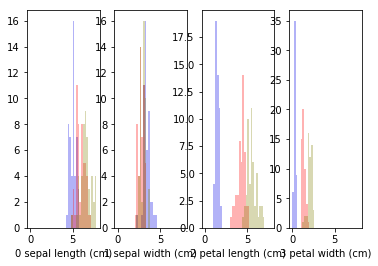

In [11]:
plt.figure()
for f, f_name in enumerate(iris['feature_names']):
    plt.subplot(1,4,f+1)
    for k in range(3): # k - klasa
        plt.hist(iris.data[iris.target==k,f],color=color_map[k],alpha=0.3,bins=np.arange(0,8,0.2))
    plt.xlabel(str(f)+' '+ f_name)
plt.show() 

Violinplot

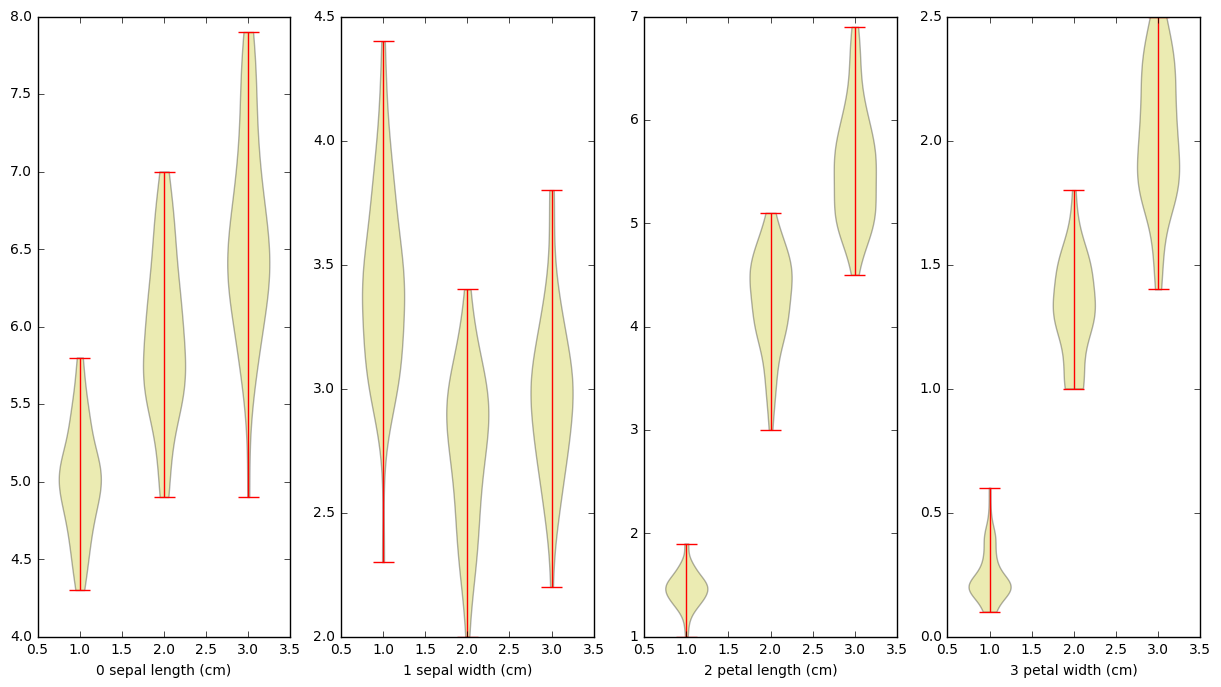

In [17]:
plt.figure()
for f, f_name in enumerate(iris['feature_names']):
    plt.subplot(1,4,f+1)
    data = np.zeros((50,3))
    for k in range(3): #
        data[:,k] = iris.data[iris.target==k,f]      
    plt.violinplot(data)
    plt.xlabel(str(f)+' '+ f_name)
plt.show() 

#### Strukturę korelacji
Tu zwróćmy uwagę na orientację macierzy podawanej do funkcji `np.cov`:

(4, 4)


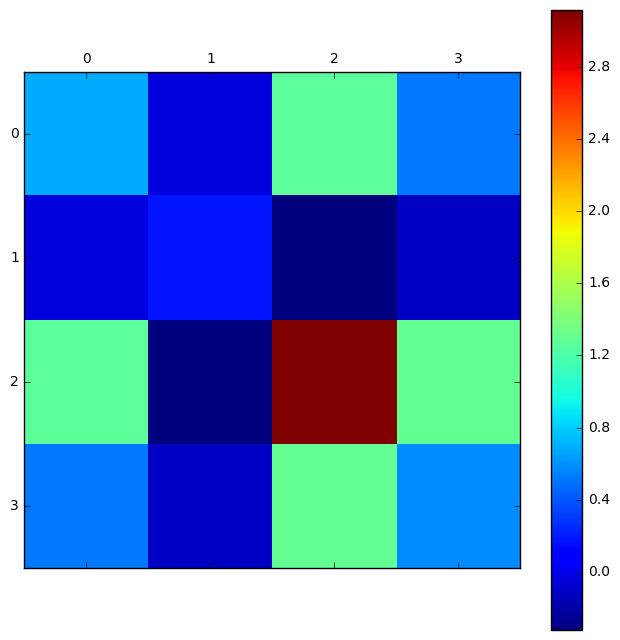

In [18]:
rho = np.cov(iris.data.T)
print(rho.shape)
plt.figure()
plt.matshow(rho)
plt.colorbar()
plt.show()

Stukturę korelacji i rozkłady można też podsumować na takim rysunku:
* w siatce prostokątnej rysujemy 
  * na przekątnej histogramy grupoweane, lub violinploty
  * pod przekątną wykres punktowy (scaterplot)

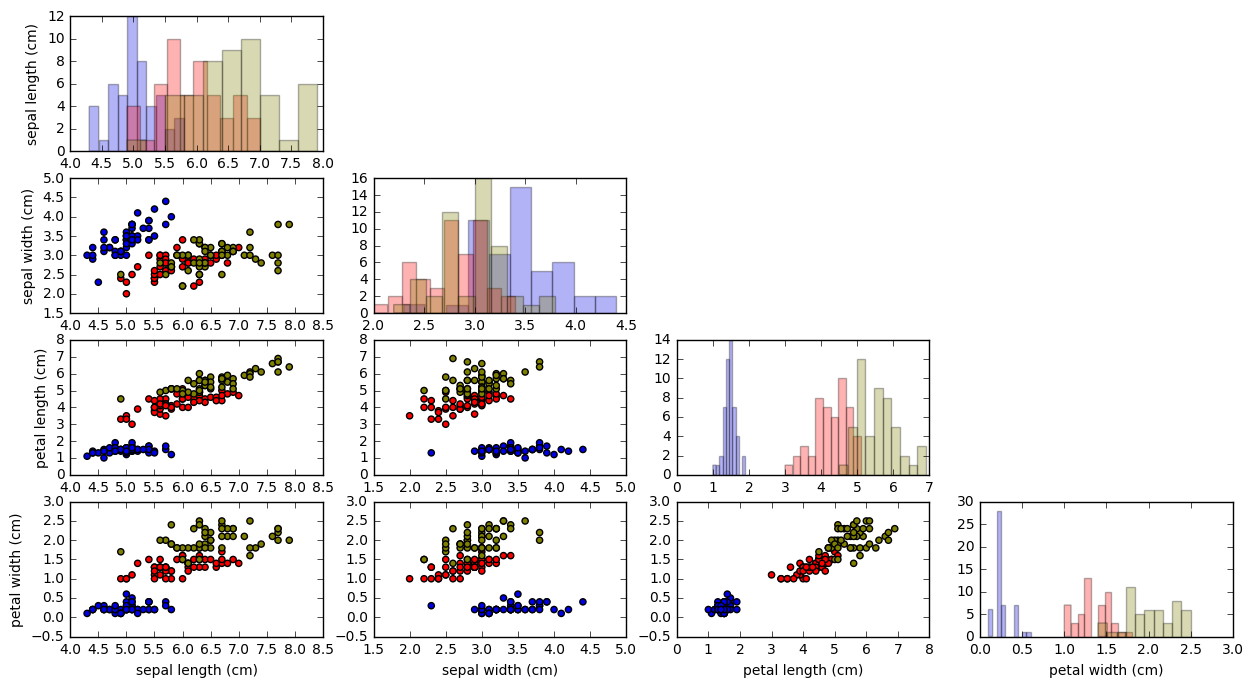

In [19]:
plt.figure(1)
for i, name_i in enumerate(iris['feature_names']):
    for j, name_j in enumerate(iris['feature_names']):
        
        if i>j:
            plt.subplot(4,4,i*4+j+1) # i numeruje wiersze, j kolumny
            plt.scatter(iris.data[:,j],iris.data[:,i],c = colors)
            
        elif i==j:
            plt.subplot(4,4,i*4+j+1) # i numeruje wiersze, j kolumny
            for k in range(3):
                plt.hist(iris.data[iris.target==k,j],color=color_map[k],alpha=0.3)
        if j ==0:
            plt.ylabel(name_i)
        if i ==3:
            plt.xlabel(name_j)
plt.show()

## Szykujemy się do zbudowania klasyfikatora
Aby było nam łatwo ilustrować jego działanie wybieramy dwie cechy (podziały przestrzeni cech da się wtedy łatwo narysować na płaszczyźnie)

* Wybieramy cechy 1 i 2 (bo są ze sobą mało skorelowane) normalizujemy je

In [ ]:
X = np.zeros((iris.data.shape[0],2))
X[:,0] = (iris.data[:,1] - np.mean(iris.data[:,1]))/np.std(iris.data[:,1])
X[:,1] = (iris.data[:,2] - np.mean(iris.data[:,2]))/np.std(iris.data[:,2])  
plt.figure(2)
plt.scatter(X[:,0],X[:,1],c = colors)  
plt.title('Wybrane cechy po normalizacji')
plt.show()

## Tworzymy i uczymy klasyfikator
Poniżej znajduje się kod służący klasyfikacji. Proszę go uzupełnić zgodnie z komentarzami i dokumentacją [http://scikit-learn.org/stable/user_guide.html]

In [ ]:
gnb = GaussianNB() # stwórz instancję klasyfikatora  Gaussian Naive Bayes 
gnb.fit(iris.data, iris.target) # dofituj parametry klasyfikatora 
gnb.theta_

#### Przedstaw rozkłady Gaussa, które zostały dopasowane do danych, skorzystaj z funkcji plot_gauss()
* średnie tych rozkładów są w gnb.theta_
* standardowe odchylenia są w gnb.sigma_

Przygotowanie siatki na której będą rysowane kontury Gaussów

In [ ]:
x_min, x_max = -3,3
y_min, y_max = -3,3
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
plt.figure(4)
for i in range(3):
    plot_gauss(...,...,xx,yy)
# dorzućmy do rysunku jeszcze oryginalne dane
plt.scatter(...,...,c = colors)
plt.title(u'Rozkłady Gaussa dopasowane do danych')
plt.show()        

## Rysowanie wyników klasyfikacji             
Przekształcamy siatkę w macierz dwukolumnową - kolumny odpowiadają cechom

In [ ]:
XX = np.c_[xx.ravel(), yy.ravel()]       

Dla każdego punktu siatki oblicz predykcję klasyfikatora  

In [ ]:
Z = ....

Te predykcje narysujemy w przestrzeni cech za pomocą funkcji  plt.contourf 

In [ ]:
plt.figure(3)
Z = Z.reshape(xx.shape)
plt.contourf(..., ..., ..., cmap=plt.cm.Paired)
# i dorzucamy oryginalne punkty
plt.scatter...
plt.title(u'Podział przestrzeni cech na klasy')
plt.show()

## Ewaluacja modelu
Teraz zajmiemy się ewaluacją dopasowanego modelu (walidacja krzyżowa). Skorzystamy z funkcji dostrczanych przez [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
* upewnij się, że dokładnie rozumiesz co zwracają te funkcje
* porównaj z definicjami z [wykładu](http://haar.zfb.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_Ocena_jakości_klasyfikacji) 

In [ ]:
...
print("classification report:")
print(classification_report...)
print("confusion matrix:")
print(confusion_matrix...)

## Porównanie  modeli
Stwórz trzy modele klasyfikatorów:
* pierwszym niech będzie korzystał z cech 1 i 2 (nasz dotychczasowy model)
* drugim niech korzysta tylko z cech 0 i 1
* trzeci niech korzysta ze wszytkich 4 cech

Porównaj miary jakości tych modeli otrzymywane za pomocą walidacji krzyżowej.

* Trzeci model można też stworzyć dla danych normalizowanych i nienormalizowanych, aby sprzwdzić czy normalizacja w tym przypadku pomaga w prawidłowej klasyfikacji.

In [ ]:
...